In [1]:
import os
from modules.reddit_data_extraction import (
    get_top_posts_and_comments,
    connect_to_reddit,
)
from modules.data_processing import load_tickers, process_data
from modules.sentiment_analysis import (
    perform_sentiment_analysis_nltk,
    average_sentiment_scores,
    print_sentiment_table,
)
from modules.market_prediction import predict_market_behavior
from config import WORK_DIR, REDDIT_CLIENT_ID, REDDIT_SECRET, REDDIT_USER_AGENT
from modules.utils import get_date_windows
from modules.visualisation import plot_data
from modules.market_prediction import (
    get_stock_data,
    calculate_trend,
    calculate_trend_reversals,
    map_sentiment_scores,
)
from datetime import datetime

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/simone/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# Define paths to files
tickers_file_path = os.path.join(WORK_DIR, "data/tickers.txt")
data_path = os.path.join(WORK_DIR, "data/top_posts_comments.json")
processed_data_path = os.path.join(WORK_DIR, "data/processed_top_posts_comments.json")
sentiment_scores_path = os.path.join(WORK_DIR, "data/sentiment_scores.json")

# Define parameters
start_date = "2018-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")  # today
post_limit = 50
comment_limit = 1000

print(
    f"We will predict today`s market behavior analysing the top post comments on the r/wallstreetbets subreddit."
)

We will predict today`s market behavior analysing the top post comments on the r/wallstreetbets subreddit.


In [3]:
# Load tickers from file
tickers = load_tickers(tickers_file_path)
print(
    f"We will predict market behavior movements only from tickers discussed in {comment_limit} "
    f"comments of today`s {post_limit} top posts. Supported tickers are: {tickers}."
)

We will predict market behavior movements only from tickers discussed in 1000 comments of today`s 50 top posts. Supported tickers are: ['AAPL', 'TSLA', 'GME', 'AMC', 'BB', 'NOK', 'SPY', 'QQQ', 'PLTR', 'MVIS', 'RKT', 'AMD', 'NVDA', 'MSFT', 'CLNE', 'CLOV', 'WKHS', 'BABA', 'ZM', 'NFLX'].


In [4]:
# Get date windows
windows = get_date_windows(start_date, end_date)
print(
    f"Given the start date {start_date} and end date {end_date}, we will analyze the histical "
    f"market behavior for each ticker on the top page of r/wallstreetbets in the following time windows: {windows}."
)

Given the start date 2018-01-01 and end date 2023-06-26, we will analyze the histical market behavior for each ticker on the top page of r/wallstreetbets in the following time windows: ['day', 'week', 'month', 'year', 'all'].


In [5]:
# Get top posts and comments from r/wallstreetbets
reddit = connect_to_reddit(REDDIT_CLIENT_ID, REDDIT_SECRET, REDDIT_USER_AGENT)
get_top_posts_and_comments(
    "wallstreetbets",
    reddit,
    data_path,
    windows=windows,
    post_limit=post_limit,
    comment_limit=comment_limit,
)

Getting top posts from r/wallstreetbets for day...
Getting top posts from r/wallstreetbets for week...
Getting top posts from r/wallstreetbets for month...
Getting top posts from r/wallstreetbets for year...
Getting top posts from r/wallstreetbets for all...


In [6]:
# Process the top posts and comments by identifying the tickers mentioned in each post and comment
process_data(data_path, tickers_file_path, windows=windows)

In [7]:
# Analyze sentiment with the nltk Vader model and save scores to file
perform_sentiment_analysis_nltk(processed_data_path, windows=windows)

In [8]:
# compute and print the average sentiment scores
avg_sentiment_scores = average_sentiment_scores(sentiment_scores_path, windows=windows)
print_sentiment_table(avg_sentiment_scores, windows=windows)

============================== day ==============================
+--------+----------+---------+----------+----------+------------+
| Ticker | Negative | Neutral | Positive | Compound | # Comments |
+--------+----------+---------+----------+----------+------------+
|  TSLA  |  0.0779  |  0.8179 |  0.1041  |  0.0318  |     37     |
|  QQQ   |  0.0463  |  0.858  |  0.0958  |  0.1182  |     11     |
|  AMC   |   0.0    |  0.707  |  0.293   |  0.6588  |     1      |
|  MSFT  |  0.0127  |  0.856  |  0.1317  |  0.5495  |     3      |
|  SPY   |  0.1082  |  0.7702 |  0.1217  |  -0.036  |     53     |
|   BB   |   0.0    |  0.9305 |  0.0695  |  0.2633  |     2      |
|  NVDA  |  0.0243  |  0.8686 |  0.1071  |  0.1429  |     25     |
|  PLTR  |   0.0    |  0.763  |  0.237   |  0.2009  |     2      |
|  AMD   |   0.0    |  0.828  |  0.172   |  0.2563  |     5      |
|  AAPL  |  0.0406  |  0.7985 |  0.1609  |  0.1698  |     8      |
|  NFLX  |   0.0    |  0.8765 |  0.1235  |  0.2787  |     2    

In [9]:
# Predict market behavior
# For each ticker we calculate the trend reversal based on the previous trading day
# moving average of the closing stock price over a time window of 5 days and 
# the sentiment score of the top posts and comments on r/wallstreetbets.
# We predict today's market behavior using the sklearn LogisticRegression model.
models = {}
for ticker in tickers:
    if ticker not in avg_sentiment_scores["day"].keys():
        continue
    print(
        f"Predicting market behavior for {ticker} "
        "based on today`s r/wallstreetbets subreddit sentiment score."
    )
    models[ticker] = predict_market_behavior(
        ticker, avg_sentiment_scores, start_date, end_date
    )

Predicting market behavior for AAPL based on today`s r/wallstreetbets subreddit sentiment score.
[*********************100%***********************]  1 of 1 completed
Model accuracy: 0.78
Model prediction: No trend reversal.
Predicting market behavior for TSLA based on today`s r/wallstreetbets subreddit sentiment score.
[*********************100%***********************]  1 of 1 completed
Model accuracy: 0.78
Model prediction: No trend reversal.
Predicting market behavior for AMC based on today`s r/wallstreetbets subreddit sentiment score.
[*********************100%***********************]  1 of 1 completed
Model accuracy: 0.82
Model prediction: No trend reversal.
Predicting market behavior for BB based on today`s r/wallstreetbets subreddit sentiment score.
[*********************100%***********************]  1 of 1 completed
Model accuracy: 0.73
Model prediction: No trend reversal.
Predicting market behavior for SPY based on today`s r/wallstreetbets subreddit sentiment score.
[**********

In [10]:
# data exploration and visualization of model predictions

# get stock data
ticker = "SPY"
stock_data = get_stock_data(ticker, start_date, end_date)

# calculate trend and trend reversals
stock_data["trend"] = calculate_trend(stock_data)
stock_data["trend_reversal"] = calculate_trend_reversals(stock_data)

# add sentiment scores
stock_data = map_sentiment_scores(stock_data, avg_sentiment_scores, ticker)

stock_data.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,moving_average,trend,prev_trend,trend_reversal,sentiment
Date,,,,,,,,,,,
2023-06-12,430.920013,433.880005,430.170013,433.799988,432.194550,76104300.0,429.481995,1.0,1.0,0.0,0.145042
2023-06-13,435.320007,437.329987,434.630005,436.660004,435.043976,95899700.0,431.207996,1.0,1.0,0.0,0.145042
2023-06-14,437.010010,439.059998,433.589996,437.179993,435.562042,100612100.0,433.333997,1.0,1.0,0.0,0.145042
2023-06-15,436.329987,443.899994,436.230011,442.600006,440.962006,110303100.0,436.027997,1.0,1.0,0.0,0.145042
2023-06-16,443.019989,443.609985,438.970001,439.459991,439.459991,114121300.0,437.939996,1.0,1.0,0.0,0.145042
2023-06-20,437.450012,438.369995,435.029999,437.179993,437.179993,76160400.0,438.615997,0.0,1.0,1.0,-0.022795
2023-06-21,436.160004,436.989990,434.329987,434.940002,434.940002,76982300.0,438.271997,0.0,0.0,0.0,-0.022795
2023-06-22,433.950012,436.619995,433.600006,436.510010,436.510010,70637200.0,438.138000,0.0,0.0,0.0,-0.022795
2023-06-23,432.929993,435.059998,432.470001,433.209991,433.209991,92028700.0,436.259998,0.0,0.0,0.0,-0.022795


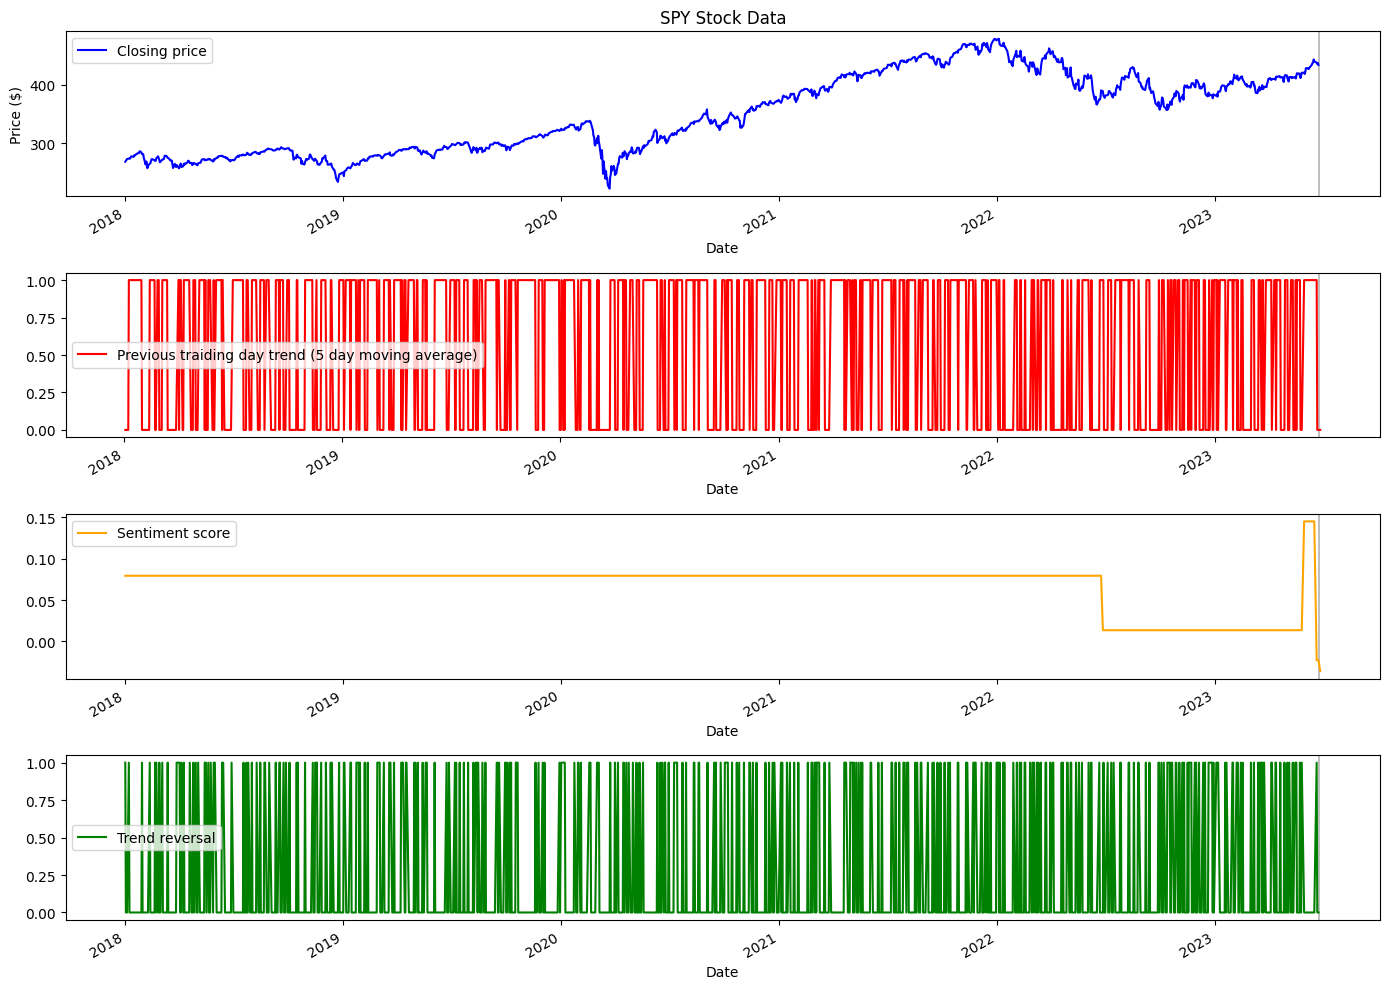

In [11]:
# plot the data
plot_data(stock_data, ticker)

In [14]:
# get today previous day trend and sentiment to predict market behavior (trennd reversal)
X_pred = stock_data[["prev_trend", "sentiment"]][-1:]
y_pred = models[ticker].predict(X_pred)[0]
print(f"Today`s trend reversal prediction for {ticker} is: {y_pred}")
print('0 means no trend reversal, 1 means trend reversal.')

Today`s trend reversal prediction for SPY is: 0.0
0 means no trend reversal, 1 means trend reversal.


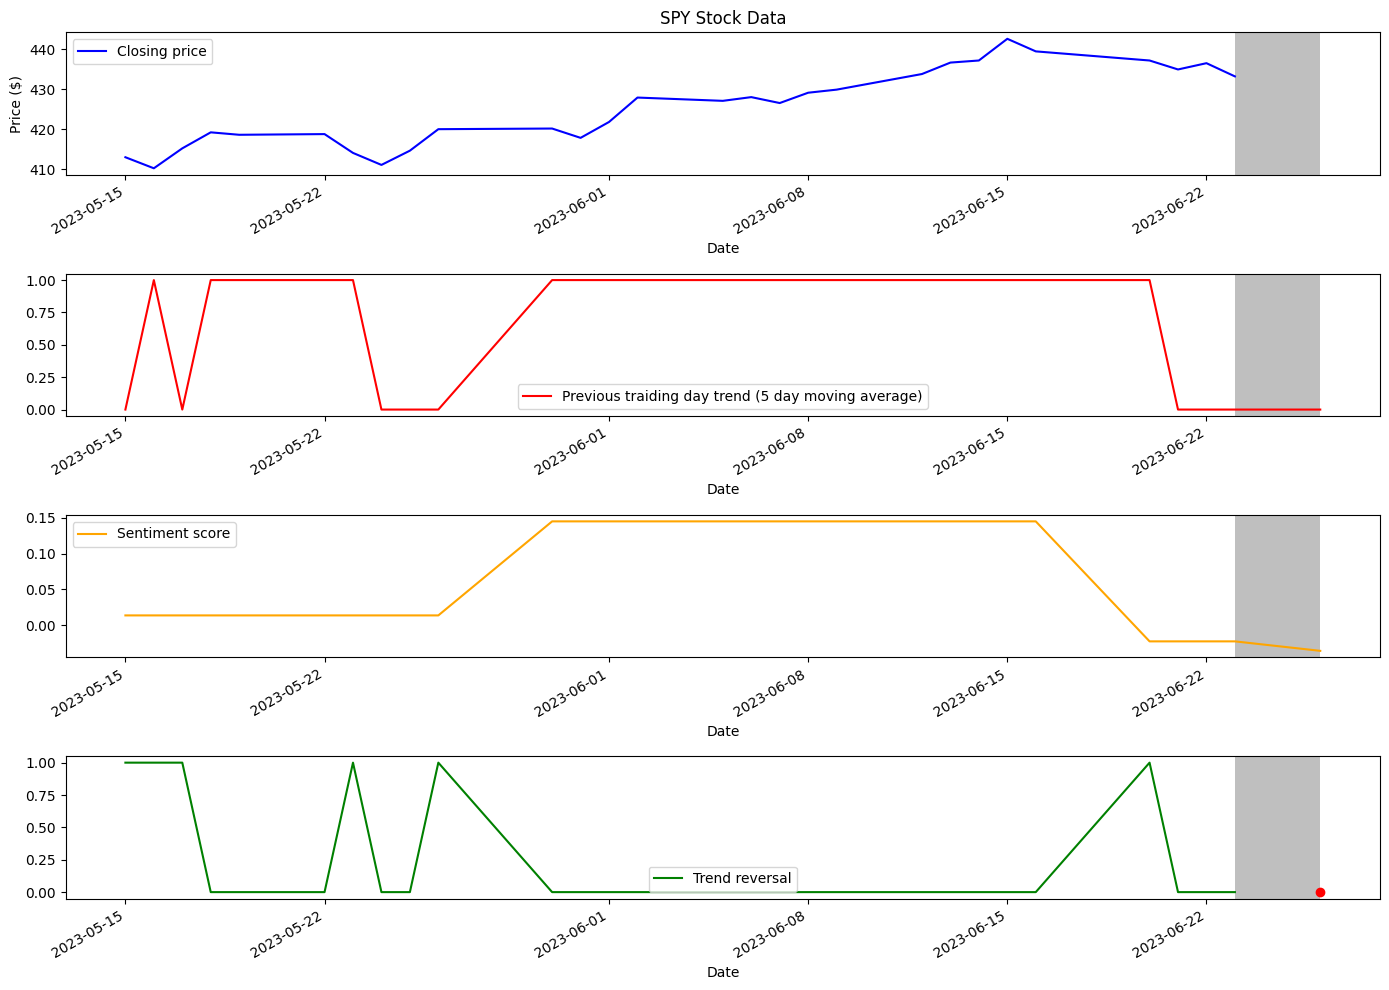

In [13]:
# let's zoom in to the last 30 days or so and visualise our model prediction
plot_data(
    stock_data, ticker, start_date="2023-05-15", end_date=end_date, prediction=y_pred
)